### SOLUTION TO A 1D BURGERS' EQUATION USING PHYSICS-INFORMED NEURAL NETWORK (PINN)

Before we delve into writing a code to solve a 1D Burgers Equation, Let us note some few things about what PINN is all about.


**PHYSICS-INFORMED DEEP LEARNING**

In simple terms, Physics-Informed Deep Learning is an approach that combines deep learning principles and knowledge of physics to solve complex scientific and engineering problems. The main ideology of physics-informed deep learning is to use a known physics of a system for regularization of the deep learning model in order to improve its accuracy and generalization.

In a regular deep learning model, large amount of data are used to train a neural network using some inputs to predict outputs without having prior knowledge about the underlying physics. While this approach has proven successful in many applications, it can be limited when the data is scarce, noisy, or incomplete, or when the physics of the problem is poorly understood.

A usual approach in physics-informed deep learning is to use a partial differential equation which explains some physical phenomenon as a constraint on the output of the neural network.

Physics-informed deep learning is a versatile approach that can be utilized in numerous problem domains, such as fluid dynamics, climate modeling, robotics, and material science. This method has demonstrated potential in resolving problems that are computationally demanding or challenging to scale with conventional techniques, or when the data is imperfect or incomplete. However, physics-informed deep learning is an evolving field of study, and several obstacles must be addressed, including the necessity for precise and consistent physical models, the selection of suitable regularization terms, and the development of effective training algorithms.



















**The 1D Burgers' Equation**

The 1D Burgers' Equation is a partial diferential equation that describes how a fluid behaves in 1-dimension.

The 1D Burgers' Equation is shown below:

$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - 0.05 \pi\frac{\partial^2 u}{\partial x^2} = 0, \quad x \in [-1,1], \quad t \in [0,1]$


where:

$0.05\pi$: is the kinematic viscosity of the fluid

$u(x,t)$: is the velocity of the fluid at a position x and time t

$u(0,x) = -sin(\pi{x})$: is the velocity of the fluid at the start of the simulation, that is at $t=0$

$u(t,-1) = u(t,1) = 0$: is the behavior of fluid at the boundaries of the pipe

$0.05 \pi\frac{\partial^2 u}{\partial x^2}$: is the diffusion of the fluid

$u\frac{\partial u}{\partial x}$: is the convection of the fluid



**General Steps to Solve Equation Using Physics-Informed Deep Learning**

To solve the 1D Burgers' Equation above we will:

1. Define an architecture for our neural network constrained with the partial differential equation above.

2. Define the loss function.

3. Use gradient descent to train the neural network

4. Perform some evaluation on the results



#### Import the Necessary Libraries

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


#### Set Global Seed for Reproducibility

In [13]:
tf.random.set_seed(42)

#### Step 1: Define an Architecture for the Neural Network

In this step, we create a class called `BurgersPINN` which inherits from the tensorflow `Model` class so we can use some functions for our class (example: trainable_variables).

The neural network to solve the 1D Burgers' equation will have two inputs, x and t, and one output, u(x,t). We will use an architecture which is fully connected, with 3 hidden layers, with each hidden layer having 20 nodes. For this problem, we will use the hyperbolic tangent function`tanh`as the activation function for the hidden layers, and the `linear` activation function for the output layer.

In [14]:
class BurgersPINN(tf.keras.Model):
    def __init__(self):
        
        """
        Function defines the hidden layers and the output layers
        with their neurons and activation functions
        
        """
        
        super().__init__() #Initializes an instance of the class
        
        #Define Hidden layers and the output Layer
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation='linear')
    
    def call(self, inputs):
        
        """
        Fits inputs to the defined hidden and output layers 
        
        """
        #Define Inputs
        x, t = inputs
        
        #Fit inputs to the defined layers
        u = tf.concat([x, t], axis=1)
        u = self.dense1(u)
        u = self.dense2(u)
        u = self.dense3(u)
        u = self.dense4(u)
        return u

#### Step 2: Define the Loss Function

In this step, we will define the loss function to be used to train our model. To do so, we create a function called `BurgersPINN_loss`, which takes the neural network or the `model`, inputs `x` and `t`, and `u_true` as arguments. u_true represents the exact solution given the initial condition and boundary of our partial differential equation. The function uses a persistent `GradientTape` API, which simple records operations for automatic differentiation. The `watch` method is used to trace the tensors x and t. The predicted solution u_pred is computed by calling the `model` on the inputs. The gradients of `u_pred` with respect to `x` and `t` are also computed.

Because we are using a physics-informed deep learning approach, there are 2 parts of our loss function:

1. A mean-squared error that computes the difference between predicted values `u_pred` and true values `u_true`.

2. A physics-informed term that enforces the Burgers' equation at every point in the domain.

The loss is then computed as the sum of the mean-squared error and mean-squared error of the residual function f. (`f_mse`)

The function returns the computed loss

In [15]:
def BurgersPINN_loss(model, x, t, u_true):
    
    """
    This function defines predicted values, compute gradients of predicted outputs with respect to each input,
    computes the mean-squared error which measures difference between predicted outputs and true output values,
    compute the residual function f, which enforces the Burgers' equation at every point of the domain,
    computes the mean-squred error of the residual, set loss as the sum of mean-squared error and mean error of residual
    function and finally returns the loss.
    """
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(x) #Traces the tensor x
        
        g.watch(t) #Traces the tensor t
        
        u_pred = model([x, t]) # Predicts output value based on defined neural network
        
        u_x = g.gradient(u_pred, x) # Computes gradients of predicted outputs with respect to x
        
        u_t = g.gradient(u_pred, t) # Computes gradients of predicted outputs with respect to x
        
        f = u_t + u_pred*u_x - 0.05*np.pi*g.gradient(u_x, x) # Physics-Informed term (residual)
        
        mse = tf.reduce_mean(tf.square(u_true - u_pred)) #Computes the mean-squared error

    f_mse = tf.reduce_mean(tf.square(f)) # Computes mean-squared error of residual
    
    loss = mse + f_mse # Final loss

    return loss

#### Step 3:  Using Gradient Descent to Train the Neural Network

Now that we have established our neural network's structure and method for evaluating its performance, we can proceed to train it using gradient descent. We will employ the Adam optimizer to optimize the weights of the neural network and train it for a total of 10,000 epochs.





In [16]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Instantiate the model
model = BurgersPINN() 


#set the loss and accuracy metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')

# Train the model
for epoch in range(1, 10001):
    with tf.GradientTape() as tape:
        
        # Generate a batch of random inputs
        x = tf.random.uniform(shape=(100,1), minval=-1, maxval=1)
        t = tf.random.uniform(shape=(100,1), minval=0, maxval=1)

        
        # The exact solution of the 1D Burgers' Partial differential equation
        # given the initial condition and boundary  
        u_true = -tf.sin(np.pi*x) 
        
        
        # Compute the Loss
        loss = BurgersPINN_loss(model, x, t, u_true)

    
    # Compute gradients and update the model
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    
    # Update the metrics
    train_loss(loss)
    train_mse(u_true, model([x, t]))

    # Print the metrics every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss={train_loss.result()}, MSE={train_mse.result()}")

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_mse.reset_states()

Epoch 1000: Loss=0.08745742589235306, MSE=0.08010309934616089
Epoch 2000: Loss=0.056246742606163025, MSE=0.052855972200632095
Epoch 3000: Loss=0.056108150631189346, MSE=0.0528341569006443
Epoch 4000: Loss=0.05570191890001297, MSE=0.0526697114109993
Epoch 5000: Loss=0.055200010538101196, MSE=0.052247148007154465
Epoch 6000: Loss=0.05518070608377457, MSE=0.052244678139686584
Epoch 7000: Loss=0.05485208332538605, MSE=0.051972124725580215
Epoch 8000: Loss=0.054896220564842224, MSE=0.05195828527212143
Epoch 9000: Loss=0.05464228242635727, MSE=0.051773931831121445
Epoch 10000: Loss=0.05494506284594536, MSE=0.05215191841125488


#### Step 4: Perform Some Evaluations on the Results

In this final step, we can assess the performance of our trained model by generating a set of coordinates in the domain, and using the trained model to predict the velocity of u(x,t) at each of these points. After which, we'll plot a contour graph to visually represent the results.

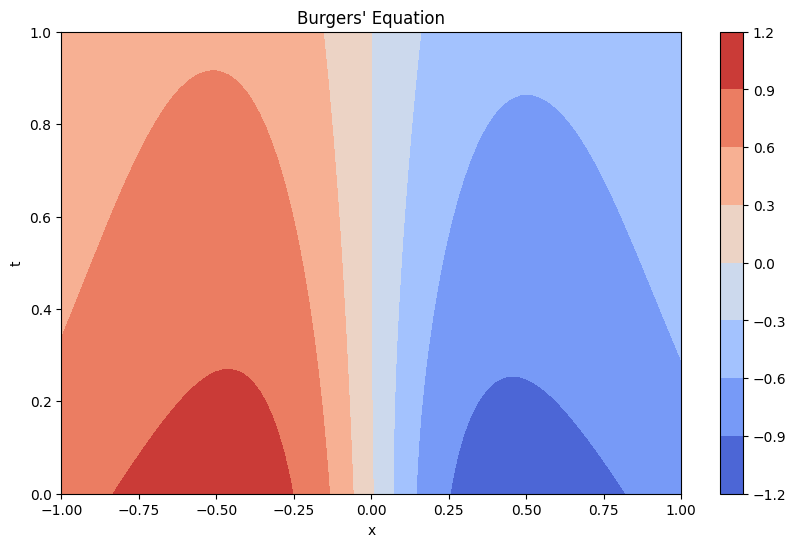

In [17]:

# Generate a grid of points in the domain
x = np.linspace(-1, 1, 101)
t = np.linspace(0, 1, 101)
x_grid, t_grid = np.meshgrid(x, t)

# Flatten the grid and use the trained model to predict the velocity
u_pred = model([x_grid.flatten()[:,None], t_grid.flatten()[:,None]])
u_pred = np.reshape(u_pred, x_grid.shape)

# Plot the results
plt.figure(figsize=(10,6))
plt.contourf(x_grid, t_grid, u_pred, cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Burgers\' Equation')
plt.show()


**One may ask:**

Why did we not predict on some generated test data in order to evaluate the model we built?




**Answer:**

To solve partial differential equations (PDEs), such as the Burgers' equation, the use of test data sets is not common as it is in traditional machine learning tasks. The objective in PDEs is to obtain a numerical solution that meets the PDE and boundary conditions, rather than predicting outcomes on unseen data.

For the Burgers' equation, the typical approach involves discretizing the PDE in space and time and numerically solving it on a grid using finite difference, finite volume, or finite element methods. The initial and boundary conditions determine the values at the grid points, and the numerical solution is obtained iteratively.

After obtaining the numerical solution, it can be evaluated using performance metrics like the L2 norm, maximum error, conservation laws, and visualization. If the solution meets the desired accuracy level, there is no need for test data sets. However, if more validation is necessary, a convergence study can be performed by refining the spatial and temporal resolutions to evaluate the accuracy of the numerical solution.

It is worth mentioning that advanced techniques such as machine learning-based methods can also be used to solve PDEs, where a data-driven approach is employed to learn the solution directly from data. In such cases, a training data set and a separate test data set can be used to train and evaluate the machine learning model. However, these approaches are more specialized and may not be as commonly used in traditional numerical PDE solutions.